## Import Packages

In [1]:
# torch 
import torch
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
# read file
import os.path as osp
import os
# read & show images
import PIL
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
# random choose
import numpy as np
from numpy import random
from numpy.random import uniform
from random import shuffle
# others
import time
import math
import argparse
import warnings
import copy
warnings.filterwarnings("ignore")

## The MTCNN Model

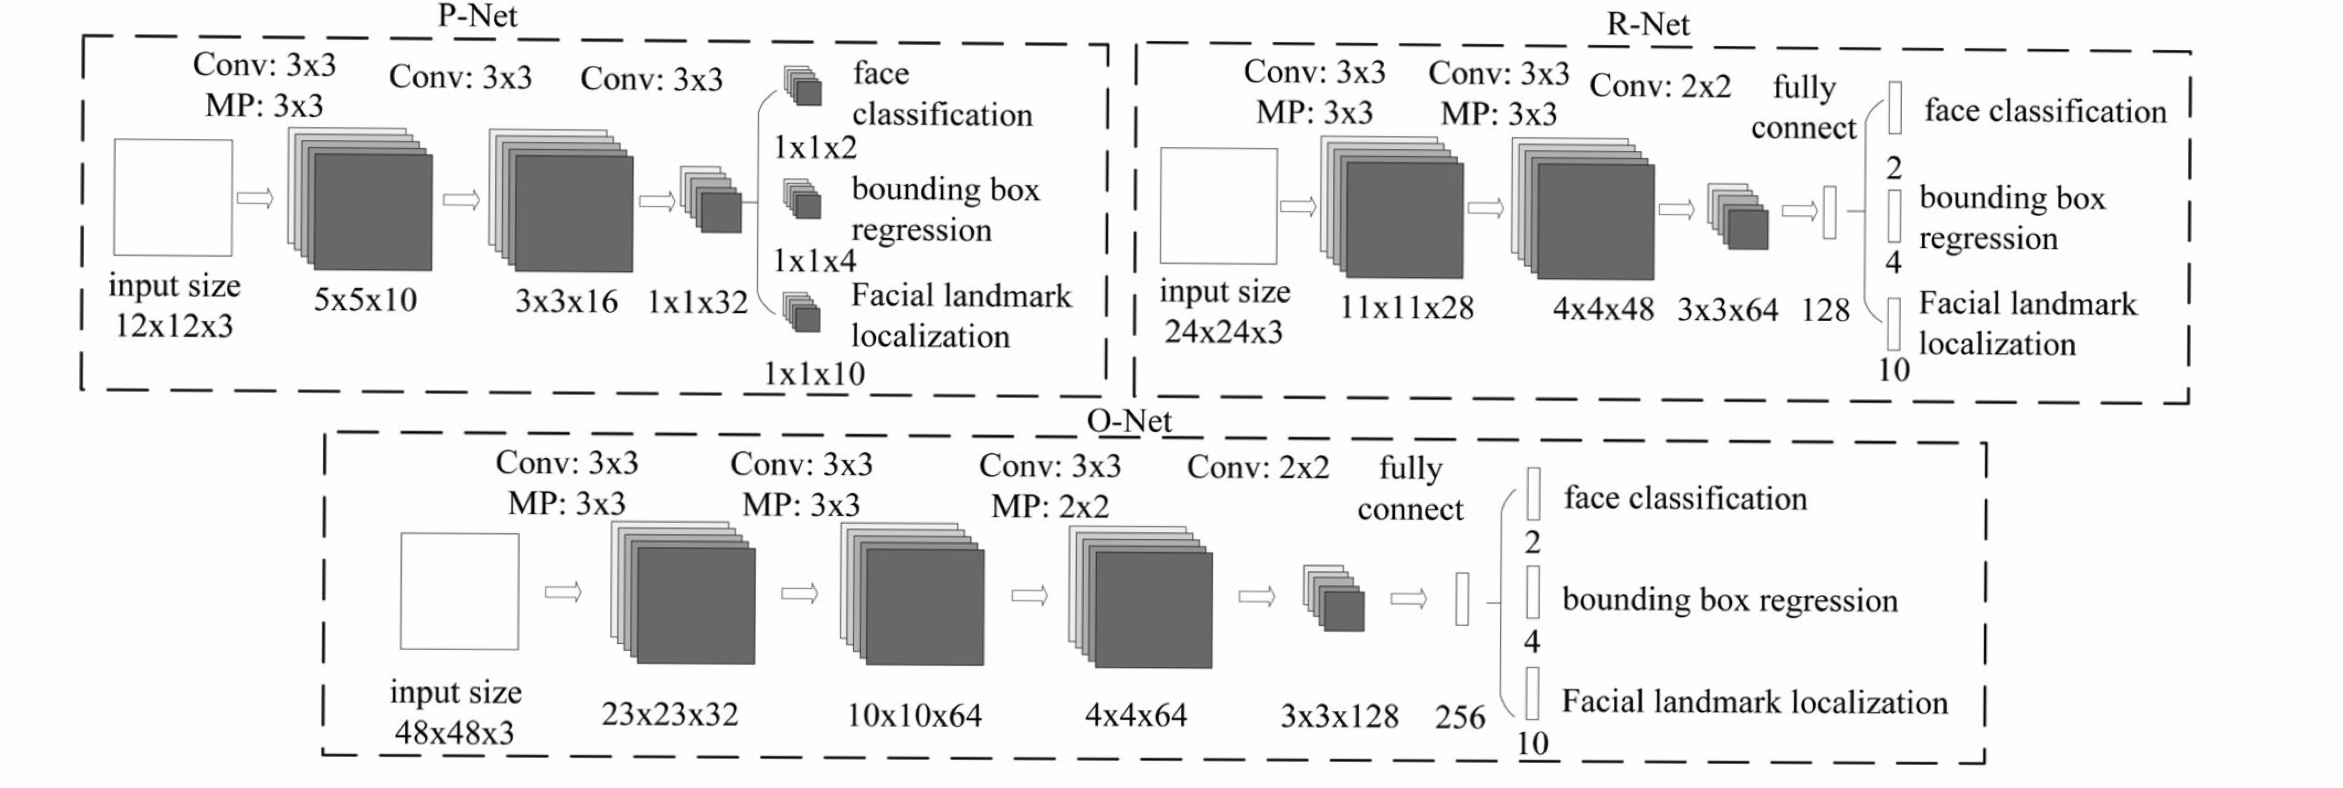

In [2]:
Image.open('MTCNN Model.jpg')

In [3]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)


class P_Net(nn.Module):
    def __init__(self):
        super(P_Net, self).__init__()
        self.pre_layer = nn.Sequential(            
            nn.Conv2d(3, 10, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # PReLU1            
            nn.MaxPool2d(kernel_size=2, stride=2),            
            nn.Conv2d(10, 16, kernel_size=3, stride=1),             
            nn.PReLU(),  
            nn.Conv2d(16, 32, kernel_size=3, stride=1),  
            nn.PReLU()  
        )
       
        self.conv4_1 = nn.Conv2d(32, 1, kernel_size=1, stride=1)        
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1, stride=1)        
        self.conv4_3 = nn.Conv2d(32, 10, kernel_size=1, stride=1)       
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        det = torch.sigmoid(self.conv4_1(x))
        box = self.conv4_2(x)
        landmark = self.conv4_3(x)
        # det:[,2,1,1], box:[,4,1,1], landmark:[,10,1,1]
        return det, box, landmark
    
class R_Net(nn.Module):
    def __init__(self):
        super(R_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            # 24x24x3
            nn.Conv2d(3, 28, kernel_size=3, stride=1),  # conv1
            nn.PReLU(), 
            nn.MaxPool2d(kernel_size=3, stride=2), 
            nn.Conv2d(28, 48, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), 
            nn.Conv2d(48, 64, kernel_size=2, stride=1),
            nn.PReLU()  # prelu3
        )
        # 2x2x64
        self.conv4 = nn.Linear(64 * 2 * 2, 128)   # 128
        self.prelu4 = nn.PReLU() 
        self.conv5_1 = nn.Linear(128, 1)
        self.conv5_2 = nn.Linear(128, 4)
        self.conv5_3 = nn.Linear(128, 10)
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv4(x)
        x = self.prelu4(x)
        det = torch.sigmoid(self.conv5_1(x))
        box = self.conv5_2(x)
        landmark = self.conv5_3(x)
        return det, box, landmark
    
class O_Net(nn.Module):
    def __init__(self):
        super(O_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=2, stride=1),
            nn.PReLU()
        )
        self.conv5 = nn.Linear(128 * 2 * 2, 256)
        self.prelu5 = nn.PReLU()
        self.conv6_1 = nn.Linear(256, 1)
        self.conv6_2 = nn.Linear(256, 4)
        self.conv6_3 = nn.Linear(256, 10)
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv5(x)
        x = self.prelu5(x)
        det = torch.sigmoid(self.conv6_1(x))
        box = self.conv6_2(x)
        landmark = self.conv6_3(x)
        return det, box, landmark


## P Net, R Net, and O Net Boxes
- In this part, it generates the output boxes of PNet, RNet, and ONet, converts them into square and calibrates them based on their offsets

In [4]:
THRESHOLDS = [0.85, 0.03, 0.5]
NMS_THRESHOLDS = [0.5, 0.9, 0.1]
MIN_FACE_SIZE = 20.0

def pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS):
    pnet.eval()
    width, height = img.size
    min_length = min(height, width)
    min_detection_size = 12
    factor = 0.707  # sqrt(0.5)
    scales = []
    m = min_detection_size / min_face_size
    min_length *= m
    factor_count = 0
    while min_length > min_detection_size:
        scales.append(m * factor ** factor_count)
        min_length *= factor
        factor_count += 1

    bounding_boxes = []
    for s in scales:  # run P-Net on different scales
        boxes = run_first_stage(img, pnet, scale=s, threshold=thresholds[0])
        bounding_boxes.append(boxes)
        # bounding_boxes shape:[scales,boxes_num_each_sale,5]
    bounding_boxes = [i for i in bounding_boxes if i is not None]

    try:
        _ = bounding_boxes[0]
    except Exception:
        img.show()
        
    if len(bounding_boxes) == 0:
        return None
    bounding_boxes = np.vstack(bounding_boxes)

    keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0])
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
    return bounding_boxes


In [5]:
def rnet_boxes(img, rnet, bounding_boxes, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS, show_boxes=True):
    rnet.eval()
    img_boxes = get_image_boxes(bounding_boxes, img, size=24)
    img_boxes = torch.FloatTensor(img_boxes)
    img_boxes=img_boxes.cuda()
    if img_boxes.size(0)==0:
        return []
    output = rnet(img_boxes)
    probs = output[0].data.cpu().numpy()  # shape [n_boxes, 1]
    offsets = output[1].data.cpu().numpy()  # shape [n_boxes, 4]

    keep = np.where(probs[:, 0] > thresholds[1])[0]
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 0].reshape((-1,))
    offsets = offsets[keep]

    keep = nms(bounding_boxes, nms_thresholds[1])
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
    if show_boxes: show_bboxes(img, bounding_boxes, []).show()
    return bounding_boxes

In [6]:
def onet_boxes(img, onet, bounding_boxes, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS):
    onet.eval()
    img_boxes = get_image_boxes(bounding_boxes, img, size=48)
    img_boxes = torch.FloatTensor(img_boxes)
    img_boxes = img_boxes.cuda()
    if img_boxes.size(0)==0:
        return []
    output = onet(img_boxes)
    probs = output[0].data.cpu().numpy()
    offsets = output[1].data.cpu().numpy()

    keep = np.where(probs[:, 0] > thresholds[2])[0]
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 0].reshape((-1,))
    offsets = offsets[keep]

    keep = nms(bounding_boxes, nms_thresholds[2])
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
    return bounding_boxes

In [7]:
def convert_to_square(bboxes):
    """
    Convert bounding boxes to a square form.
    """
    square_bboxes = np.zeros_like(bboxes)
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    h = y2 - y1 + 1.0
    w = x2 - x1 + 1.0
    max_side = np.maximum(h, w)
    square_bboxes[:, 0] = x1 + w * 0.5 - max_side * 0.5
    square_bboxes[:, 1] = y1 + h * 0.5 - max_side * 0.5
    square_bboxes[:, 2] = square_bboxes[:, 0] + max_side - 1.0
    square_bboxes[:, 3] = square_bboxes[:, 1] + max_side - 1.0
    return square_bboxes


def calibrate_box(bboxes, offsets):
    """
        Transform bounding boxes to be more like true bounding boxes.
        'offsets' is one of the outputs of the nets.
    """
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w = x2 - x1 + 1.0
    h = y2 - y1 + 1.0
    # w [w_len, 1]
    w = np.expand_dims(w, 1)
    # h [h_len, 1]
    h = np.expand_dims(h, 1)

    translation = np.hstack([w, h, w, h]) * offsets
    bboxes[:, 0:4] = bboxes[:, 0:4] + translation
    return bboxes


def get_image_boxes(bounding_boxes, img, size=24):
    """ Cut out boxes from the image. """
    try:
        num_boxes = len(bounding_boxes)
    except:
        return []
    if num_boxes==0:
        return []
    # print('bounding_boxes:', bounding_boxes)
    width, height = img.size

    [dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bounding_boxes, width, height)
    img_boxes = np.zeros((num_boxes, 3, size, size), 'float32')

    for i in range(num_boxes):
        img_box = np.zeros((h[i], w[i], 3), 'uint8')

        img_array = np.asarray(img, 'uint8')
        # print('img_array.shape:', img_array.shape)
        img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] = \
            img_array[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]

        img_box = Image.fromarray(img_box)
        img_box = img_box.resize((size, size), Image.BILINEAR)
        img_box = np.asarray(img_box, 'float32')

        img_boxes[i, :, :, :] = img_normalization(img_box)

    return img_boxes


def correct_bboxes(bboxes, width, height):
    """
        Crop boxes that are too big and get coordinates
    with respect to cutouts.
    """
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w, h = x2 - x1 + 1.0, y2 - y1 + 1.0
    num_boxes = bboxes.shape[0]

    x, y, ex, ey = x1, y1, x2, y2
    dx, dy = np.zeros((num_boxes,)), np.zeros((num_boxes,))
    edx, edy = w.copy() - 1.0, h.copy() - 1.0

    ind = np.where(ex > width - 1.0)[0]
    edx[ind] = w[ind] + width - 2.0 - ex[ind]
    ex[ind] = width - 1.0

    ind = np.where(ey > height - 1.0)[0]
    edy[ind] = h[ind] + height - 2.0 - ey[ind]
    ey[ind] = height - 1.0

    ind = np.where(x < 0.0)[0]
    dx[ind] = 0.0 - x[ind]
    x[ind] = 0.0

    ind = np.where(y < 0.0)[0]
    dy[ind] = 0.0 - y[ind]
    y[ind] = 0.0
    return_list = [dy, edy, dx, edx, y, ey, x, ex, w, h]
    return_list = [i.astype('int32') for i in return_list]

    return return_list


def img_normalization(img):
    """Preprocessing step before feeding the network. """
    img = img.transpose((2, 0, 1))
    img = np.expand_dims(img, 0)
    # *0.0078125 i.e. 除以128
    img = (img - 127.5) * 0.0078125
    return img


In [8]:
def IoU(box, boxes):
    """
    Compute IoU between detect box and gt boxes
    """
    # box = (x1, y1, x2, y2)
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)

    # abtain the offset of the interception of union between crop_box and gt_box
    xx1 = np.maximum(box[0], boxes[:, 0])
    yy1 = np.maximum(box[1], boxes[:, 1])
    xx2 = np.minimum(box[2], boxes[:, 2])
    yy2 = np.minimum(box[3], boxes[:, 3])

    # compute the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    inter = w * h
    ovr = inter / (box_area + area - inter)
    return ovr


## Run the First Stage (PNet)
- In this part, it runs the P-Net to generate bounding boxes, and do NMS.

In [9]:
def run_first_stage(image, net, scale, threshold):
    width, height = image.size
    sw, sh = math.ceil(width * scale), math.ceil(height * scale)
    img = image.resize((sw, sh), Image.BILINEAR)
    # img = np.asarray(img, 'float32')
    img = transforms.ToTensor()(img).unsqueeze(0)
    img = img.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    # print('img:', img)

    output = net(img)
    probs = output[0].data.cpu().numpy()[0, 0, :, :]
    # offsets shape[4, o_h,o_w]
    offsets = output[1].data.cpu().numpy()
    # print('offsets:', offsets)
    # boxes
    boxes = _generate_bboxes(probs, offsets, scale, threshold)
    if len(boxes) == 0:
        return None

    # [[x1,y1,x2,y2,score,offsets],[]...]
    keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
    return boxes[keep]

def _generate_bboxes(probs, offsets, scale, threshold):
    """
       Generate bounding boxes at places where there is probably a face.
    """
    stride = 2
    cell_size = 12

    inds = np.where(probs > threshold)
    
    if inds[0].size == 0:
        return np.array([])
    # offsets shape[4, o_h,o_w]
    tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
    # for i in zip(tx1, ty1, tx2, ty2):
    #     print([i[j] for j in range(4)])

    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[inds[0], inds[1]]
    # print('score:', score)

    # P-Net is applied to scaled images, so we need to rescale bounding boxes back
    bounding_boxes = np.vstack([
        np.round((stride * inds[1] + 1.0) / scale),
        np.round((stride * inds[0] + 1.0) / scale),
        np.round((stride * inds[1] + 1.0 + cell_size) / scale),
        np.round((stride * inds[0] + 1.0 + cell_size) / scale),
        score, offsets
    ])

    return bounding_boxes.T

def nms(boxes, overlap_threshold=0.5, mode='union'):
    """ Pure Python NMS baseline. """
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = boxes[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        if mode is 'min':
            ovr = inter / np.minimum(areas[i], areas[order[1:]])
        else:
            ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= overlap_threshold)[0]
        order = order[inds + 1]
    return keep

## Set Parameters and Load Models

In [125]:
demo_folder_path='../input/test-demo/Test Demo'
demo_img_path=[os.path.join(demo_folder_path,name) for name in  os.listdir(demo_folder_path)]
pnet_weight_path='../input/for-rnet/pnet_10000_40.pkl'
rnet_weight_path='../input/rnet-weights/rnet_12798_60_1.pkl'
onet_weight_path='../input/onet-weights/onet_12708_60_2.pkl'
pnet=P_Net().cuda()
pnet.load_state_dict(torch.load(pnet_weight_path))
pnet.eval()
rnet=R_Net().cuda()
rnet.load_state_dict(torch.load(rnet_weight_path))
rnet.eval()
onet=O_Net().cuda()
onet.load_state_dict(torch.load(onet_weight_path))
onet.eval()

O_Net(
  (pre_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): PReLU(num_parameters=1)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (10): PReLU(num_parameters=1)
  )
  (conv5): Linear(in_features=512, out_features=256, bias=True)
  (prelu5): PReLU(num_parameters=1)
  (conv6_1): Linear(in_features=256, out_features=1, bias=True)
  (conv6_2): Linear(in_features=256, out_features=4, bias=True)
  (conv6_3): Linear(in_features=256, out_features=10, bias=True)
)

## Show The MTCNN Performance

In [126]:
def show_boxes(img, bounding_boxes):
    plt.imshow(img)
    for b in bounding_boxes:
        plt.gca().add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=1))
    plt.show()

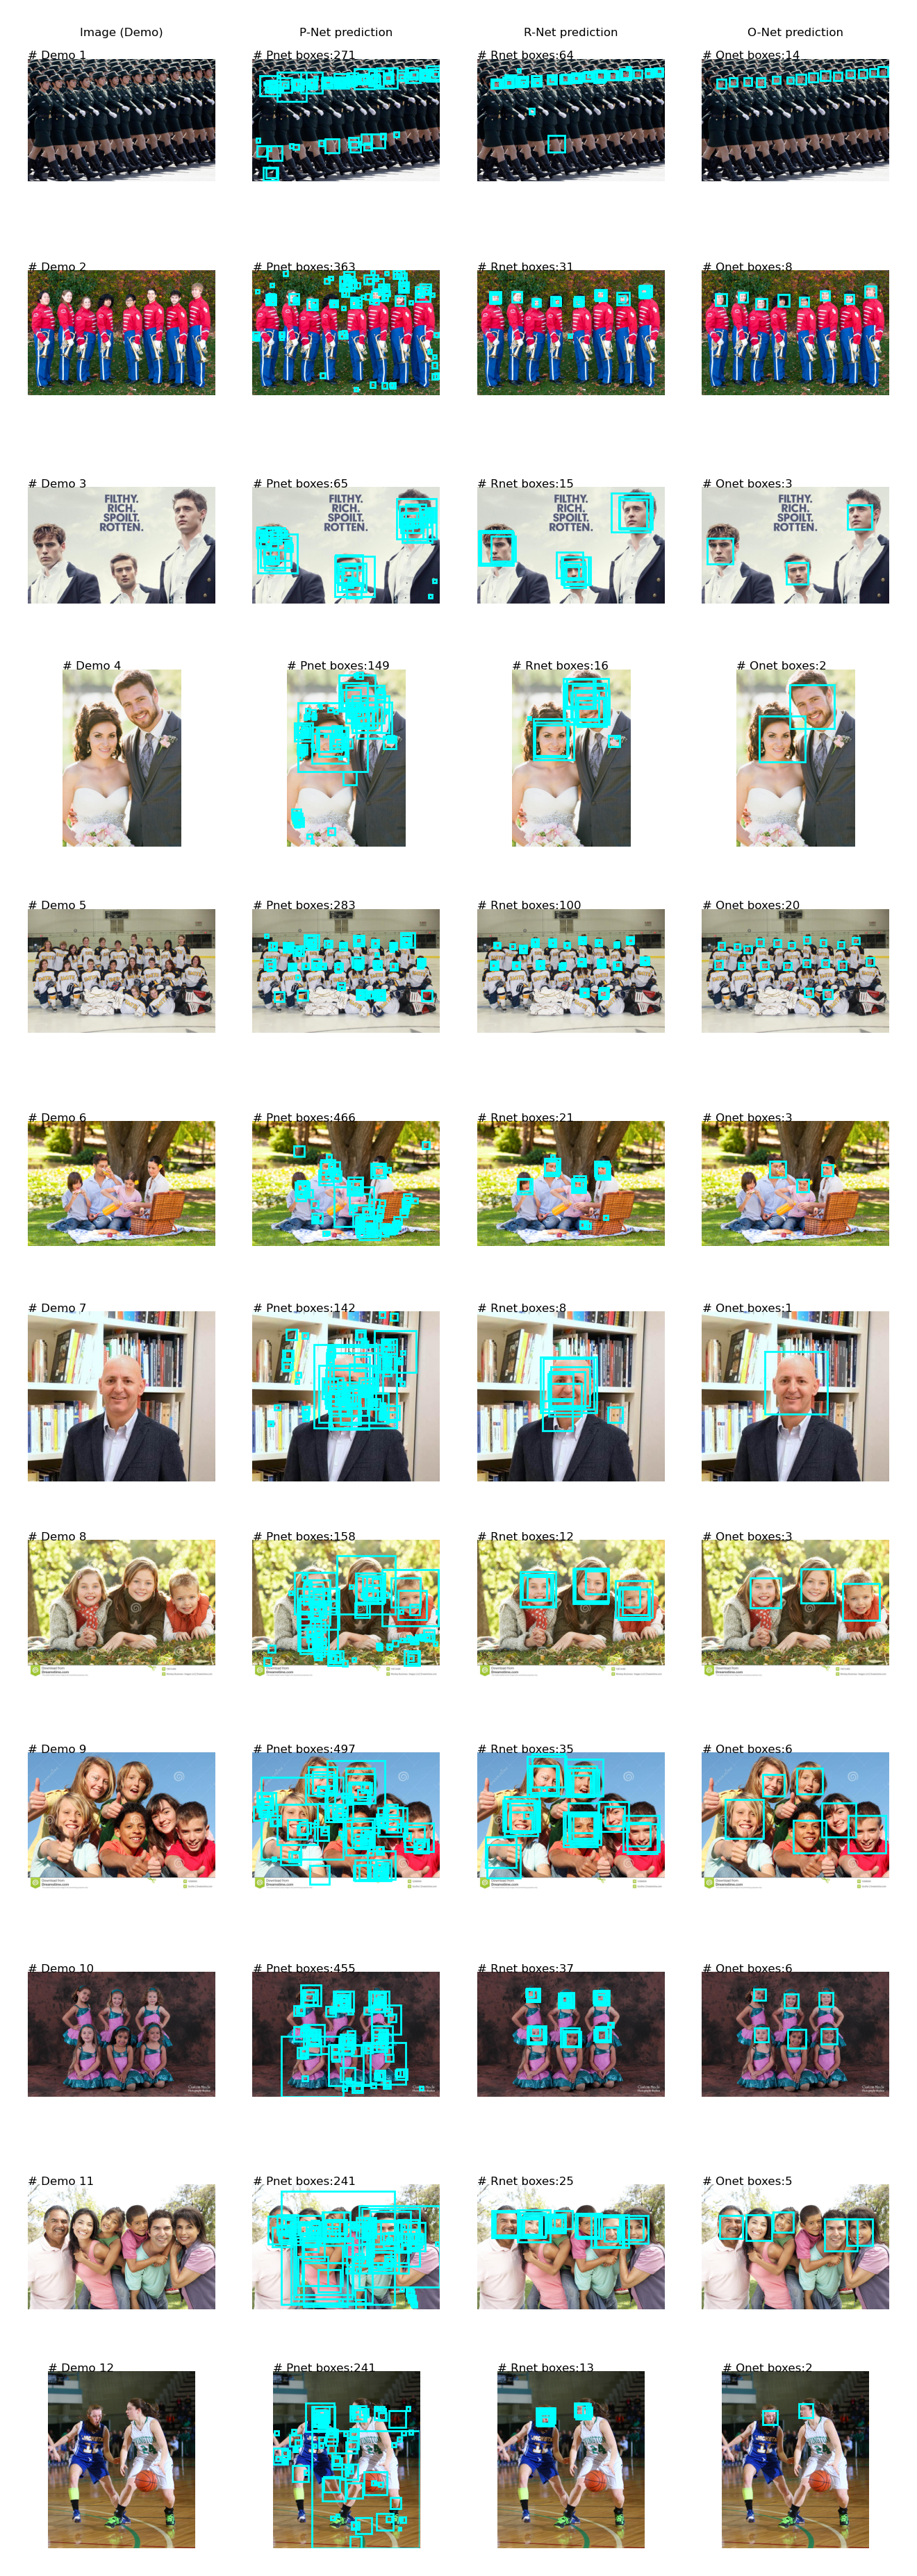

In [127]:
fig, ax = plt.subplots(12,4,dpi = 400, figsize=(4,12))

for i in range(len(demo_img_path)):
    img = Image.open(demo_img_path[i])
    p_bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    r_bounding_boxes=rnet_boxes(img, rnet, p_bounding_boxes, show_boxes=False)
    o_bounding_boxes=onet_boxes(img, onet, r_bounding_boxes)
    p_bounding_boxes=[] if p_bounding_boxes is None else p_bounding_boxes
    r_bounding_boxes=[] if r_bounding_boxes is None else r_bounding_boxes
    o_bounding_boxes=[] if o_bounding_boxes is None else o_bounding_boxes
    
    ax[i,0].imshow(img)  
    ax[i,0].text(0, 0, '# Demo '+str(i+1),fontsize=3)
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# Pnet boxes:'+str(len(p_bounding_boxes)),fontsize=3)
    for b in p_bounding_boxes[:100]:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
    
    ax[i,2].imshow(img)
    ax[i,2].text(0, 0, '# Rnet boxes:'+str(len(r_bounding_boxes)),fontsize=3)
    for b in r_bounding_boxes:
        ax[i,2].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
        
    ax[i,3].imshow(img)
    ax[i,3].text(0, 0, '# Onet boxes:'+str(len(o_bounding_boxes)),fontsize=3)
    for b in o_bounding_boxes:
        ax[i,3].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   


for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Image (Demo)",fontsize=3)
ax[0][1].set_title("P-Net prediction",fontsize=3)
ax[0][2].set_title("R-Net prediction",fontsize=3)
ax[0][3].set_title("O-Net prediction",fontsize=3)
fig.show()
fig.savefig('demo_Test.png')